In [1]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from pathlib import Path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [3]:
# Set paths
base = Path('/content/drive/MyDrive/flickr30k_images/')
imgdir = Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')

eff_dir = Path('/content/drive/MyDrive/efficientnet_flickr30k/')
eff_features_path = Path('/content/drive/MyDrive/efficientnet_flickr30k/eff_features.pkl')



### EfficientNetV2 Fact sheet

| Attribute | Description |
|----------|-------------|
| **Developed by** | **Google Research** (Mingxing Tan & Quoc V. Le) |
| **Released** | **May 2021**, accepted to ICML 2021 |
| **Training Dataset** | Pretrained on **ImageNet21K** (**14 million images, 21K classes**), then fine-tuned on **ImageNet1K** (1.2 million images, 1K classes) |
| **Variants** | EfficientNetV2-S, V2-M, V2-L, V2-XL — scaled for speed and accuracy |
| **Architecture Type** | CNN with compound scaling, MBConv blocks, and Fused-MBConv for early layers |
| **Optimization** | Uses **neural architecture search (NAS)** to balance training speed and model size |
| **Performance** | V2-L achieves ~85.7% top-1 accuracy on ImageNet1K; V2-XL reaches ~**87.2%** |
| **Speed Gains** | Up to 5× faster training than EfficientNetV1, with fewer parameters and FLOPs |



### Load EfficientNetV2

In [ ]:
# Load EfficientNetV2-S without top layer
base_model = EfficientNetV2S(weights='imagenet', include_top=False, pooling='avg')

eff_model = Model(inputs=base_model.input, outputs=base_model.output)

eff_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        648 │ rescaling[0][0]   │
│                     │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,184 │ stem_activation[… │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, None,      │          0 │ block1a_project_… │
│                     │ None, 24)         │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 24)         │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

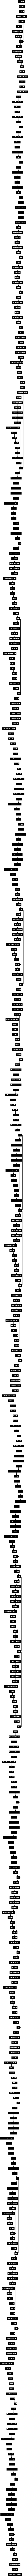

In [ ]:
plot_model(eff_model, show_shapes=False)

In [ ]:
import pickle
from pathlib import Path
from tensorflow.keras.preprocessing import image
import numpy as np

# Load existing features if available
eff_features_path = Path('/content/drive/MyDrive/efficientnet_flickr30k/eff_features.pkl')
if eff_features_path.exists():
    with open(eff_features_path, 'rb') as f:
        eff_features = pickle.load(f)
    print(f"🔄 Resuming from {len(eff_features)} saved features.")
else:
    eff_features = {}
    print("🆕 Starting fresh feature extraction.")

# Image directory
imgdir = Path('/content/drive/MyDrive/flickr30k_images/flickr30k_images/')
img_paths = list(imgdir.glob('*.jpg'))

# Extraction loop
save_every = 50
counter = 0

for img_path in img_paths:
    key = f"efficientnetv2_{img_path.name}"
    if key in eff_features:
        continue  # Skip already processed image

    try:
        img = image.load_img(img_path, target_size=(384, 384))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        feature = eff_model.predict(x, verbose=0)
        eff_features[key] = feature.flatten()
        counter += 1

        if counter % save_every == 0:
            with open(eff_features_path, 'wb') as f:
                pickle.dump(eff_features, f)
            print(f"💾 Saved {len(eff_features)} features so far...")

    except Exception as e:
        print(f"⚠️ Failed to process {img_path.name}: {e}")

# Final save
with open(eff_features_path, 'wb') as f:
    pickle.dump(eff_features, f)
print(f"✅ Final save complete. Total features: {len(eff_features)}")

🔄 Resuming from 31783 saved features.
✅ Final save complete. Total features: 31783


In [4]:
# Reload efficient image features
with open(eff_features_path, 'rb') as f:
    eff_features = pickle.load(f)
print(type(eff_features))  # should be dict
print("EfficientNet Image features loaded:", len(eff_features))

<class 'dict'>
EfficientNet Image features loaded: 31783


In [5]:
# Utility: Reload environment after runtime reset
import pickle

# Reload mapping
with open('/content/drive/MyDrive/flickr30k_images/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)
print("Mapping loaded:", len(mapping))

# Reload all_captions
with open('/content/drive/MyDrive/flickr30k_images/all_captions.pkl', 'rb') as f:
    all_captions = pickle.load(f)
print("All captions loaded:", len(all_captions))

# Reload tokenizer
with open('/content/drive/MyDrive/flickr30k_images/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Tokenizer vocabulary size:", len(tokenizer.word_index))

# Reload metadata
with open('/content/drive/MyDrive/flickr30k_images/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
vocab_dict = meta['vocab_dict']
vocab_size = meta['vocab_size']
max_length_cap = meta['max_length_cap']
print("Vocab size:", vocab_size)
print("Max caption length:", max_length_cap)

Mapping loaded: 31783
All captions loaded: 158914
Tokenizer vocabulary size: 17892
Vocab size: 17893
Max caption length: 74


In [8]:
#Train test split
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)

train_id = image_ids[:split]
print(len(train_id))

test_id = image_ids[split:]
print(len(test_id))

28604
3179


In [9]:
for i in mapping.keys():
    print(i)
    break

for i in eff_features.keys():
    print(i)
    print(type(eff_features[i]))
    print(eff_features[i].dtype)

    break

for i in train_id:
    print(i)
    break


1000092795.jpg
efficientnetv2_7808530252.jpg
<class 'numpy.ndarray'>
float32
1000092795.jpg


In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random

def data_generator(data_keys, mapping, tokenizer, eff_features, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        random.shuffle(data_keys)
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]
                    if out_seq == 0:
                        continue
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    assert f"efficientnetv2_{key}" in eff_features, f"Missing feature: efficientnetv2_{key}"
                    feature = eff_features.get(f"efficientnetv2_{key}")
                    assert feature.shape == (1280,), f"Bad shape: {feature.shape}"
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = [], [], []
                n = 0

In [10]:
batch_size = 64
steps_per_epoch = len(train_id) // batch_size

train_generator = data_generator(train_id, mapping, tokenizer, eff_features, max_length_cap, vocab_size, batch_size=batch_size)
test_generator = data_generator(test_id, mapping, tokenizer, eff_features, max_length_cap, vocab_size, batch_size=batch_size)

In [ ]:
# test one batch before training
batch = next(train_generator)
print(type(batch))
print("Batch shapes:", [x.shape for x in batch[0]], batch[1].shape)

<class 'tuple'>
Batch shapes: [(3589, 1280), (3589, 74)] (3589,)


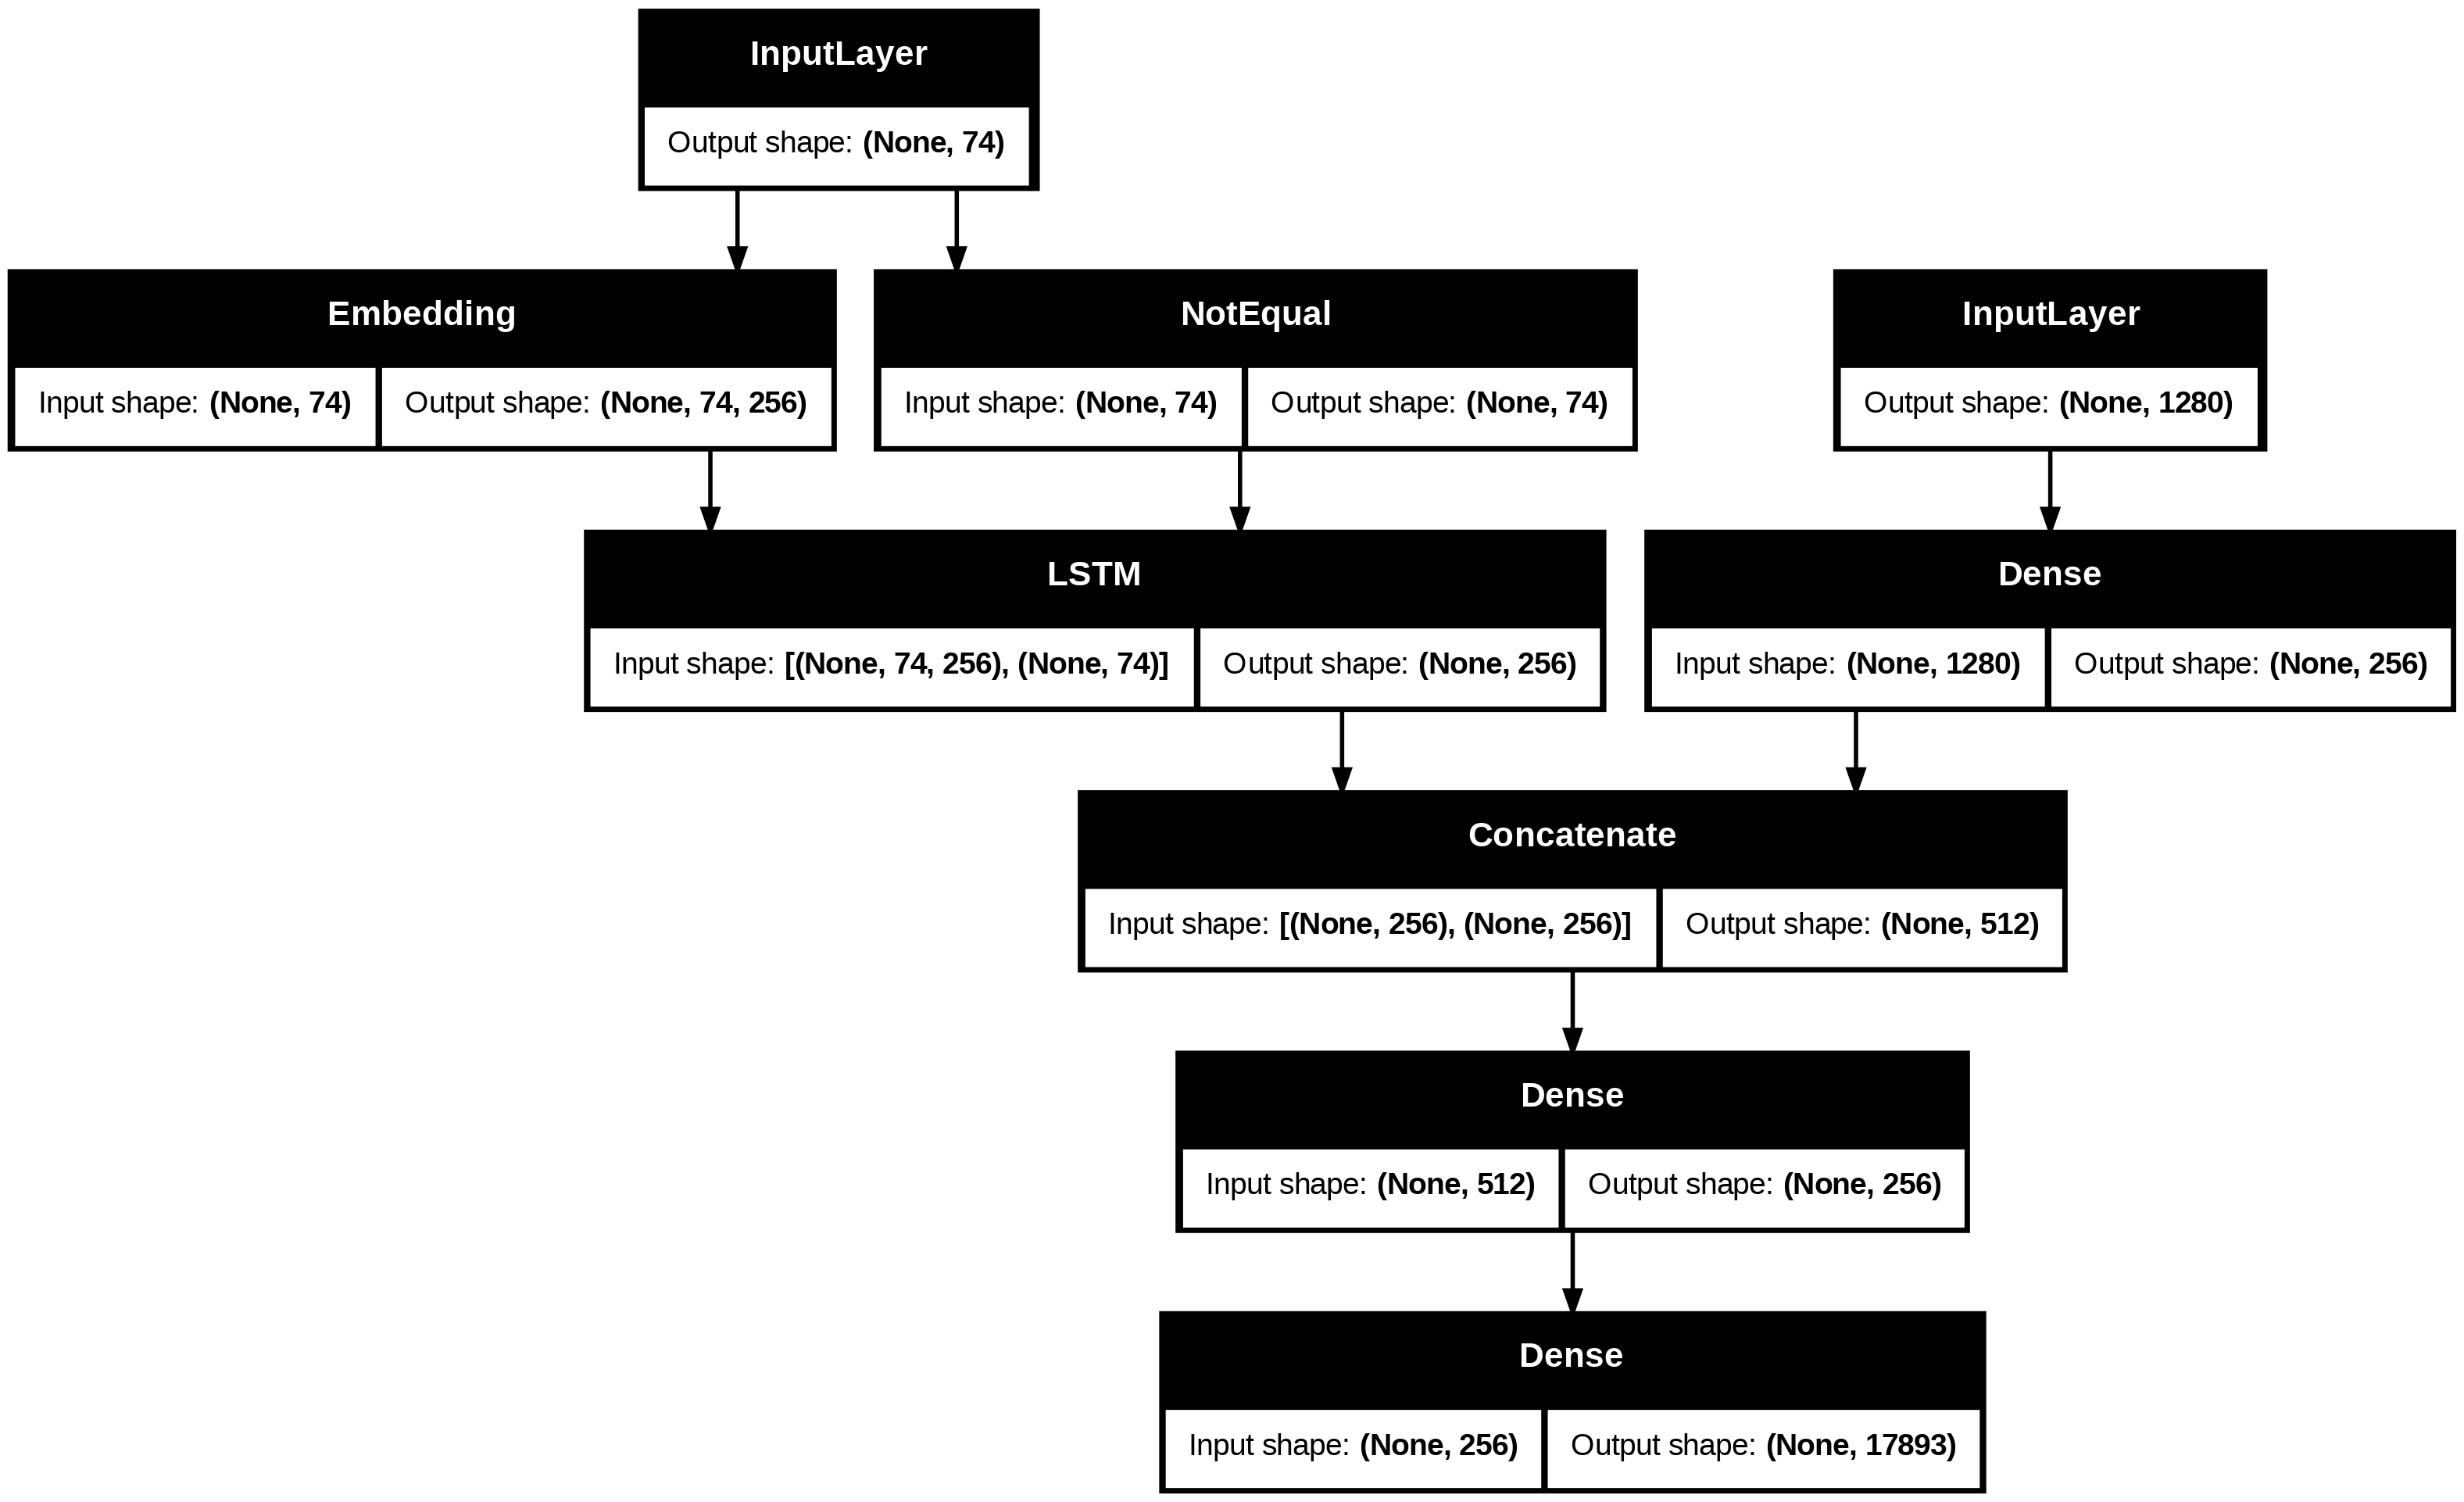

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate
from tensorflow.keras.utils import plot_model

# Image feature input
image_input = Input(shape=(1280,), name='image_input')  # EfficientNetV2-S outputs 1280-dim
img_dense = Dense(256, activation='relu')(image_input)

# Caption input
caption_input = Input(shape=(max_length_cap,), name='caption_input')
caption_embed = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
caption_lstm = LSTM(256)(caption_embed)

# Combine image and caption
merged = Concatenate(name='merg_concat')([img_dense, caption_lstm])
dense1 = Dense(256, activation='relu')(merged)
output = Dense(vocab_size, activation='softmax')(dense1)

# Final model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,580,608 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 74)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merg_concat         │ (None, 512)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ merg_concat[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 17893)     │  4,598,501 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,163,685 (38.77 MB)

 Trainable params: 10,163,685 (38.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import pickle
import numpy as np

# Initialize history dictionary
eff_history = {'loss': [], 'accuracy': []}

# Training parameters
epochs = 100
batch_size = 64
steps = len(train_id) // batch_size

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    # Re-instantiate generator each epoch
    generator = data_generator(train_id, mapping, tokenizer, eff_features, max_length_cap, vocab_size, batch_size)

    # Train for one epoch
    history = model.fit(generator,
                        epochs=1,
                        steps_per_epoch=steps,
                        verbose=1)

    # Track metrics
    eff_history['loss'].append(history.history['loss'][0])
    if 'accuracy' in history.history:
        eff_history['accuracy'].append(history.history['accuracy'][0])

    # Save model and history every 5 epochs
    if epoch % 10 == 0:
        model.save(f'/content/drive/MyDrive/efficientnet_flickr30k/eff_model.keras')
        with open('/content/drive/MyDrive/efficientnet_flickr30k/eff_history.pkl', 'wb') as f:
            pickle.dump(eff_history, f)
        print(f"✅ Saved model and history at epoch {epoch}")

Epoch 1/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 78s 161ms/step - accuracy: 0.1465 - loss: 5.7661
✅ Saved model and history at epoch 0
Epoch 2/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 75s 167ms/step - accuracy: 0.2833 - loss: 3.8165
Epoch 3/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 74s 166ms/step - accuracy: 0.3152 - loss: 3.4281
Epoch 4/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.3328 - loss: 3.2088
Epoch 5/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 74s 167ms/step - accuracy: 0.3506 - loss: 3.0297
Epoch 6/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 75s 167ms/step - accuracy: 0.3649 - loss: 2.9010
Epoch 7/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.3776 - loss: 2.7920
Epoch 8/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 73s 163ms/step - accuracy: 0.3901 - loss: 2.6995
Epoch 9/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.3996 - loss: 2.6291
Epoch 10/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 73s 163ms/step - accuracy: 0.4090 - loss: 2.5611
Epoch 11/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 73s 163ms/step - acc

In [ ]:
model.save(f'/content/drive/MyDrive/efficientnet_flickr30k/eff_model.keras')
with open('/content/drive/MyDrive/efficientnet_flickr30k/eff_history.pkl', 'wb') as f:
    pickle.dump(eff_history, f)
print(f"✅ Saved model and history at epoch {epoch}")

In [12]:
from tensorflow.keras.models import load_model
import pickle

eff_model = load_model('/content/drive/MyDrive/efficientnet_flickr30k/eff_model.keras')

with open('/content/drive/MyDrive/efficientnet_flickr30k/eff_history.pkl', 'rb') as f:
    eff_history = pickle.load(f)

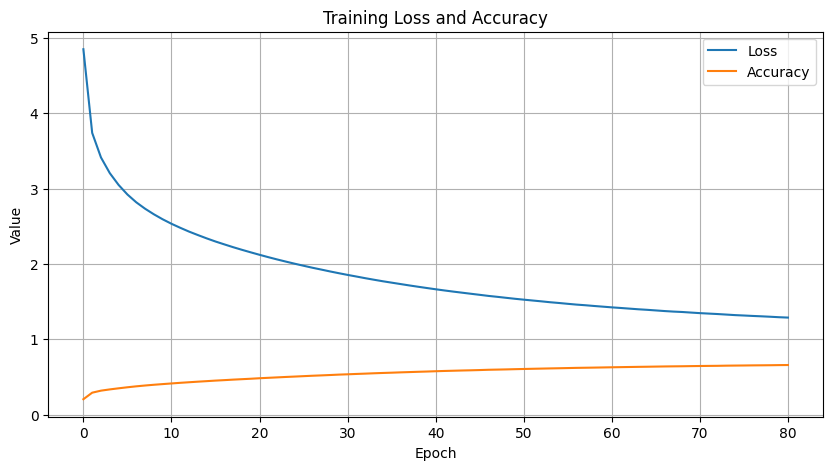

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(eff_history['loss'], label='Loss')
plt.plot(eff_history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Caption quality evaluation with BLEU metric

**BLEU**

**What it does**: Compares generated captions to reference captions using n-gram overlap.

**What it tells:** How close the generated captions are to human-written ones.

---
**BLEU** is designed to measure overlap and to tolerate variation. For example:

- **Reference**: "a man is riding a horse on the beach"
- **Prediction**: "a man riding a horse"
→ This prediction doesn’t match the reference, but it has strong n-gram overlap.
---
- Strengths:

  - Evaluates full sentence quality.

  - Standard in image captioning benchmarks.

- Limitations:

  - Sensitive to exact word choice and order.

  - Doesn’t capture meaning or creativity well.


---
####  What Is a "Good" BLEU Score?

- **BLEU-1 (unigrams)**: Measures overlap of individual words  
  - Scores around **0.5–0.7** are considered decent  
- **BLEU-2 to BLEU-4**: Measure n-gram overlap (phrases)  
  - Scores **drop sharply** as n increases  
  - For BLEU-4, even **0.3–0.4** can be strong for image captioning

> BLEU scores in image captioning are **lower than in machine translation**, because captions are short and diverse and multiple valid descriptions exist for the same image.



In [14]:
# Caption generator function
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq '  # same as preproccess
    for _ in range(max_length):
        # Encode and pad input sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        # Predict the next word
        yhat = model.predict([image, seq], verbose=0)
        next_index = np.argmax(yhat)
        next_word = tokenizer.index_word.get(next_index)

        # Stop if word is unknown or end token
        if next_word is None or next_word == 'endseq':
            break

        # Append word to input sequence
        in_text += ' ' + next_word

    return in_text.replace('startseq', '').strip()

### Define evaluation

In [15]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

def evaluate_model(model, ids, mapping, features, tokenizer, max_length):
    actual, predicted = [], []
    for img_id in tqdm(ids, desc="Evaluating BLEU"):
        feature = features.get(f"efficientnetv2_{img_id}").reshape(1, 1280)
        y_pred = predict_caption(model, feature, tokenizer, max_length)
        references = [caption.split()[1:-1] for caption in mapping[img_id]]  # remove startseq/endseq
        actual.append(references)
        predicted.append(y_pred.split())
    return actual, predicted

### Run evaluation

In [16]:
from nltk.translate.bleu_score import corpus_bleu

# Evaluate model and get actual vs predicted captions
actual, predicted = evaluate_model(eff_model, test_id, mapping, eff_features, tokenizer, max_length_cap)

# Compute BLEU scores
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

# Print results
print(f"BLEU-1: {bleu1:.4f} → measures overlap of individual words (unigrams): Word-level overlap")
print(f"BLEU-2: {bleu2:.4f} → measures overlap of 2-word sequences (bigrams): Phrase-level accuracy")
print(f"BLEU-3: {bleu3:.4f} → measures overlap of 3-word sequences (trigrams): Sentence structure")
print(f"BLEU-4: {bleu4:.4f} → measures overlap of 4-word sequences (4-grams): Full caption fluency")



Evaluating BLEU: 100%|██████████| 3179/3179 [1:26:57<00:00,  1.64s/it]


BLEU-1: 0.4223 → measures overlap of individual words (unigrams): Word-level overlap
BLEU-2: 0.2216 → measures overlap of 2-word sequences (bigrams): Phrase-level accuracy
BLEU-3: 0.1171 → measures overlap of 3-word sequences (trigrams): Sentence structure
BLEU-4: 0.0576 → measures overlap of 4-word sequences (4-grams): Full caption fluency


### Show sample caption generation

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import os

BASE_DIR = '/content/drive/MyDrive/flickr30k_images/flickr30k_images/'

def visualize_prediction(image_name):
    image_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print('_______________________Actual_________________')
    for caption in mapping[image_name]:
        print(caption.replace('startseq', '').replace('endseq', '').strip())

    y_pred = predict_caption(eff_model, eff_features.get(f"efficientnetv2_{image_name}").reshape(1, 1280), tokenizer, max_length_cap)
    print('_____________________Predicted________________')
    print(y_pred)

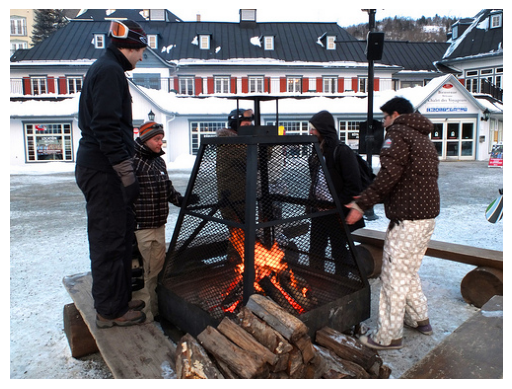

_______________________Actual_________________
five young men huddle around fire outside where it is snowy and cold
skiers and snowboarders warm themselves by the fire while they talk
group of friends around fire protected with metallic mesh
five men stand around bonfire with log benches around it
people trying to get warm
_____________________Predicted________________
two people are standing around fire at rodeo


In [24]:
import random

# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

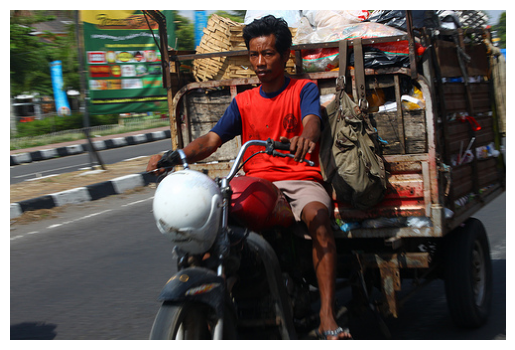

_______________________Actual_________________
man wearing red and blue shirt rides motorcycle pulling of equipment
man riding on bike with pile of things in large wooden crate behind him
man is riding motorcycle and towing trailer filled with stuff
this man is driving motorcycle with junks with his back
man driving motorcycle and towing load
_____________________Predicted________________
two boys are driving down the street on motorized bike


In [27]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

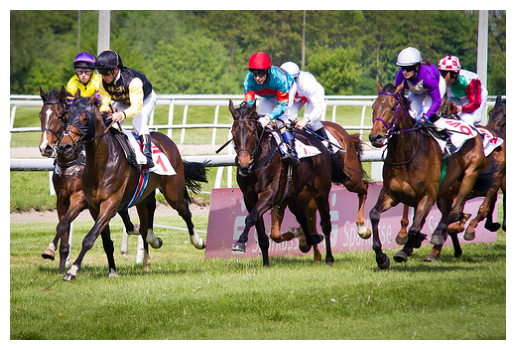

_______________________Actual_________________
jockeys in brightly colored outfits are racing on their horses in the green grass
horse race with numerous people on the horses in grassy scene
group of jockeys are riding racehorses on grass track
six jockeys racing horses on grass track
horses and jockeys running in turf race
_____________________Predicted________________
three jockeys race horses


In [28]:
# Pick a random image ID from the test set
IMG = random.choice(test_id)

# Visualize the prediction for that image
visualize_prediction(IMG)

🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓

### **CONCLUSION**:
### The main issue portrayed in this project is that the model does not truly "**pay attention**" to the images. That’s exactly where **modern deep learning** enters the realm of **attention mechanisms** and **transformers**. I believe the whole point of this project is to show why we need transformers and attention:; because with the current setup, even the best achievable accuracy is unable to produce meaningful captions. No matter how much we tweak, without attention, the model simply doesn’t have the capability to see the image the way it should.


🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓
### With this final note, which indicates the need for **further study** and **continuous learning**, I end my internship. Thanks to everyone at **CS_Internship** whose **generosity** and **integrity** provided me with this great opportunity. Thank you! ❤️
🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓📜🎓